# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал, вмете с новыми фиками добавил количество поисков на последний месяц и неделю. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные значения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

7) Кластеризация. Очень долго ей занимался, сейчас подведу итоги всех трех дней. Главная идея такая - модель уже использует агригаты, так что для того чтобы повысить качество нужно использовать какую то иную информацию. Первое что проходит на ум - запросы человека. Банально провести кластеризацию на запросах и потом построить на этих метках новые агрегаты. Но есть проблема, у нас 77кк строк запросов и даже если написать нормальный алгоритм это будет работать 19 часов. Помимо того на сэмпле и понижении размерности через PCA выяснилось, что данные это полосы, крупные классы запиывают мелкие и те забиваются одной неразделимой кучей в углу, не получается чегото адекватного даже если использовать гауссовскую кластеризациюд или GMM. 300к обьектов обрабатывались несколько минут и я решил сделать кластеризацию полуавтоматически. Я создал столбец 'cluster' и заполнил его -1. Построив кластеризацию на 10_000 обьектах выделил некоторые классы, они ясно выделаются, например 20-30 обьектов с словом "вода" в названии, и заполнил их метки руками. Потом снова построил кластеризацию на оставшихся. Леноточная структура осталась, но обьекты былит уже другими. за каждую такую итерацию отсеивалось от 3кк до 10кк обьектов. Итого у меня определилось 18 кластеров - напитки, питомцы, мясо и многое другое. В итоге еще осталось 23кк обьектов, но там очень сложно выделить группы. В принципе я могу свести их до 10кк, но вопрос есть ли в этом смысл. После таких не простых манипуляций мы получаем метки, но это просто инструмент. То что реально даст прирост качества это агрегаты. Не просто было придумать их и не все оказались удачными. Я добавил последний доминирующий кластер, концентрация интересов, переключения между кластерами, стабильность кластеров, время в основном кластере, среднее время между сменами кластеров, средняя длина запроса, разница длины запросов. В итоге скор получился 0.8221.

8) Итак, начинаем агрегацию через knn, начальный скор без поли фичей и кластеризации по поиску - 0.8208
9) Косле knn скор 0.8209, нет особо смысла это делать при таких условиях, потому что я данных много пропусков. Вернее в тех столбцах, на которых запускал я много пропусков, нужно было попробовать меньшее количество столбцов, но сейчас я хочу в отдельном файле сконцентрораваться на генерации признаков, их трансформации и кодирвоании. 

--------------------------------------------

--------------------------------------------

In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


In [7]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [8]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [9]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [10]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [11]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"
    )

In [12]:
# search_aggs
id_ = 4
suf = 'search'

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [13]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

num_cols = ['num_products_click', 'sum_discount_price_click', 'max_discount_price_click', 'days_since_last_click', 'days_since_first_click', 
    'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite', 'days_since_last_favorite', 
    'days_since_first_favorite', 'num_products_order', 'sum_discount_price_order', 'max_discount_price_order', 'days_since_last_order', 
    'days_since_first_order', 'num_products_to_cart', 'sum_discount_price_to_cart', 'max_discount_price_to_cart', 'days_since_last_to_cart', 
    'days_since_first_to_cart']

In [14]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

cols = [
    # Существующие столбцы
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
]

In [15]:
knn_cols = list(filter(lambda x: x not in cols, ['num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite', 'last_favorite_time', 'first_favorite_time', 'days_since_last_favorite', 'days_since_first_favorite']))

In [20]:
from local_utils import *

df_knn = add_knn_features_faiss(df_pd, knn_cols, 'target', n_neighbors=5, use_gpu=True)
df_knn

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done
KNN features created


,user_id,target,num_products_click,sum_discount_price_click,max_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,num_products_favorite,...,knn_last_favorite_time_median,knn_last_favorite_time_sum,knn_last_favorite_time_range,knn_first_favorite_time_mean,knn_first_favorite_time_max,knn_first_favorite_time_min,knn_first_favorite_time_std,knn_first_favorite_time_median,knn_first_favorite_time_sum,knn_first_favorite_time_range
0,5189717,0,3.0,1419.0,500.0,2024-06-05 15:57:32,2024-06-05 15:56:14,25.0,25.0,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
1,632492,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
2,522368,1,282.0,101127.0,3290.0,2024-06-26 20:40:38,2024-03-02 09:13:58,4.0,120.0,1.0,...,2.666864,13.335056,0.001309,3.250695,3.251701,3.250147,0.000576,3.250522,16.253475,0.001553
3,343314,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
4,5064034,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874951,2005235,0,6.0,39289.0,9690.0,2024-05-24 06:22:57,2024-04-19 15:58:22,37.0,72.0,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
1874952,736387,0,4.0,4388.0,1890.0,2024-06-29 19:28:58,2024-06-29 19:24:23,1.0,1.0,NaN,...,-0.422183,-2.110916,0.000000,-0.414040,-0.414040,-0.414040,0.000000,-0.414040,-2.070202,0.000000
1874953,6091522,1,31.0,12649.0,2949.0,2024-06-29 04:28:11,2024-06-18 05:23:28,1.0,12.0,2.0,...,2.881799,14.409439,0.001014,3.505606,3.506266,3.505064,0.000420,3.505501,17.528031,0.001203
1874954,8321075,0,8.0,1482.0,404.0,2024-06-06 11:32:27,2024-03-29 08:58:23,24.0,93.0,1.0,...,2.652590,13.262614,0.001212,3.233441,3.233894,3.232569,0.000478,3.233440,16.167206,0.001325


In [21]:
tr, val = get_split(df_knn, val_size=0.3)

In [23]:
tr.columns

Index(['user_id', 'target', 'num_products_click', 'sum_discount_price_click',
       'max_discount_price_click', 'last_click_time', 'first_click_time',
       'days_since_last_click', 'days_since_first_click',
       'num_products_favorite', 'sum_discount_price_favorite',
       'max_discount_price_favorite', 'last_favorite_time',
       'first_favorite_time', 'days_since_last_favorite',
       'days_since_first_favorite', 'num_products_order',
       'sum_discount_price_order', 'max_discount_price_order',
       'last_order_time', 'first_order_time', 'days_since_last_order',
       'days_since_first_order', 'num_products_to_cart',
       'sum_discount_price_to_cart', 'max_discount_price_to_cart',
       'last_to_cart_time', 'first_to_cart_time', 'days_since_last_to_cart',
       'days_since_first_to_cart', 'num_search', 'unique_search_queries',
       'num_search_last_month', 'num_search_last_week',
       'days_since_last_search', 'days_since_first_search', 'last_search_time',
      

In [49]:
cols = ['num_products_click',
 'sum_discount_price_click',
 'max_discount_price_click',
 'days_since_last_click',
 'days_since_first_click',
 'num_products_favorite',
 'sum_discount_price_favorite',
 'max_discount_price_favorite',
 'days_since_last_favorite',
 'days_since_first_favorite',
 'num_products_order',
 'sum_discount_price_order',
 'max_discount_price_order',
 'days_since_last_order',
 'days_since_first_order',
 'num_products_to_cart',
 'sum_discount_price_to_cart',
 'max_discount_price_to_cart',
 'days_since_last_to_cart',
 'days_since_first_to_cart',
 'num_search',
 'days_since_last_search',
 'days_since_first_search',
 'knn_distance_mean',
 'knn_distance_max',
 'knn_distance_min',
 'knn_distance_std',
 'knn_distance_range',
 'knn_last_favorite_time_mean',
 'knn_last_favorite_time_max',
 'knn_last_favorite_time_min',
 'knn_last_favorite_time_std',
 'knn_last_favorite_time_median',
 'knn_last_favorite_time_sum',
 'knn_last_favorite_time_range',
 'knn_first_favorite_time_mean',
 'knn_first_favorite_time_max',
 'knn_first_favorite_time_min',
 'knn_first_favorite_time_std',
 'knn_first_favorite_time_median',
 'knn_first_favorite_time_sum',
 'knn_first_favorite_time_range']

In [50]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453008, number of negative: 859460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8896
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 41
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345157 -> initscore=-0.640394
[LightGBM] [Info] Start training from score -0.640394
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 60 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [2070  608  554  685  364  365  107  343   60  168 1316 1359  739 1655
 2189 1407 1249  634  642  978 1313  752  822   21   42    0   35    0
   19   26   28   57   18    0   85   15   19   11   31   10    0   84] 



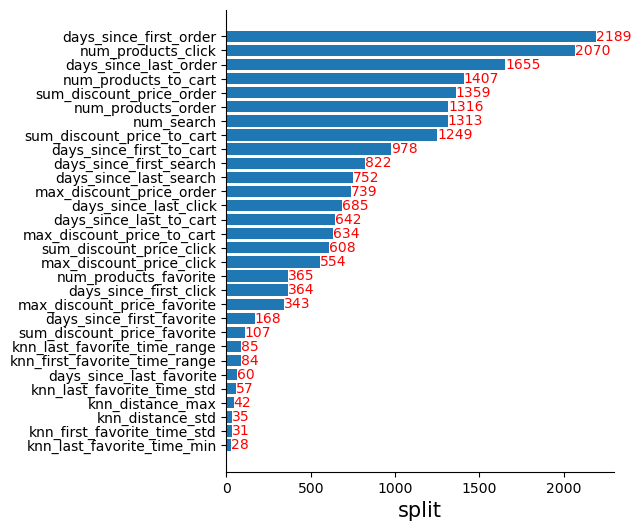

In [51]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [52]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_76236\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [53]:
id_ = 4
suf = 'search'


actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),


        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [59]:
df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

In [60]:
from local_utils import *

knn_feature_means = df_knn[["knn_distance_mean", "knn_target_mean"]].mean()

# На тесте убираем `target` и применяем средние значения KNN
df_pd = add_knn_features_faiss(df_pd, knn_cols, None, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done
KNN features created


In [61]:
from local_utils import *

df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

In [62]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.158315
1,9852,0.728463
2,10206,0.219022
3,11317,0.217862
4,13289,0.574860
...,...,...
2068419,11157283,0.222977
2068420,11160395,0.147187
2068421,11165052,0.594548
2068422,11168218,0.487071


In [64]:
df_pd[['user_id', 'predict']].to_csv('knn_res.csv', index=False)